<a href="https://colab.research.google.com/github/databs1/med_price_prediction/blob/master/Price_prediction_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os 
os.chdir("/content/drive/My Drive/Colab Notebooks/")
os.getcwd()

'/content/drive/My Drive/Colab Notebooks'

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt 
import pandas as pd 
import re
import itertools
import operator
import sys
!{sys.executable} -m pip install Unidecode
import unidecode
import seaborn as sns
import statsmodels.api as sm
import json
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoLarsCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
#import importlib
#moduleName = input('Enter module name:')
#importlib.import_module(moduleName)
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('french')) 
from xgboost import XGBRegressor
!{sys.executable} -m pip install prince
from prince import FAMD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
%run diagnose.py
%run searchp.py
from diagnose import LinearRegressionResidualPlot
from searchp import EstimatorSelectionHelper  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Data preprocessing and feature engineering

We import the `substances.csv` file as a first step containing the name of all substances found in the training and test set, the file has duplicate values.
We eliminate all the duplicate values by joining the text on the same training label "1_train,2_train,..." and looking for the 30 most common words.

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/med_prices/")
df = pd.read_csv(os.getcwd()+"/train.csv")
substances = pd.read_csv("/content/drive/My Drive/Colab Notebooks/med_prices/substances.csv")
df.head()
substances_train = substances[substances.id.str.contains(r'\d_train')]
substances_train = substances_train.groupby("id")[["substance"]].transform(lambda x : ' '.join(x)).iloc[substances_train["id"].drop_duplicates().index,:].reset_index(drop=True)

In [ ]:
pref_stop_words = ["de","base"]

sub = [''.join([z.strip(string.punctuation) for z in unidecode.unidecode(i).lower()]) for i in substances_train["substance"]]
sub = [[z for z in i if z not in pref_stop_words] for i in [i.split() for i in sub]]
sub = pd.Series([' '.join([z for z in i]) for i in sub])
from collections import Counter
print([{x:y} for (x,y) in Counter(' '.join(sub).split()).most_common(30) if len(x)>4])
labels = [x for (x,y) in Counter(' '.join(sub).split()).most_common(30) if len(x)>4]
labels = [[z for z in i.split() if z in labels] for i in sub]
print("Number of missing values: {}".format(pd.Series([set(i) if i != [] else np.nan for i in labels]).isna().value_counts().drop(index=0).values[0]))
labels = pd.Series([set(i) if i != [] else np.nan for i in labels]).str.join('|').str.get_dummies()
labels

[{'chlorhydrate': 1359}, {'sodique': 544}, {'hydrochlorothiazide': 471}, {'anhydre': 448}, {'acide': 329}, {'perindopril': 291}, {'atorvastatine': 282}, {'amoxicilline': 268}, {'sodium': 218}, {'dihydrate': 205}, {'monohydrate': 205}, {'metformine': 202}, {'trihydratee': 191}, {'calcique': 177}, {'valsartan': 173}, {'pantoprazole': 172}, {'acetate': 165}, {'losartan': 161}, {'esomeprazole': 160}, {'chlorure': 160}, {'potassique': 153}, {'calcium': 151}, {'maleate': 142}, {'glucose': 139}, {'irbesartan': 129}, {'amlodipine': 128}, {'besilate': 127}, {'dichlorhydrate': 123}, {'bisoprolol': 122}]
Number of missing values: 4445


,acetate,acide,amlodipine,amoxicilline,anhydre,atorvastatine,besilate,bisoprolol,calcique,calcium,chlorhydrate,chlorure,dichlorhydrate,dihydrate,esomeprazole,glucose,hydrochlorothiazide,irbesartan,losartan,maleate,metformine,monohydrate,pantoprazole,perindopril,potassique,sodique,sodium,trihydratee,valsartan
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
8562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
days_diff = pd.to_datetime(df['date declar annee'],format='%Y%m%d') - pd.to_datetime(df['date amm annee'],format='%Y%m%d')
df_misc = pd.concat([pd.get_dummies(df.iloc[:,2:5])
                     ,df['tx rembours'].apply(lambda x: x.strip("%")).astype("float").apply(lambda x : x/100)
                     ,pd.get_dummies(df.iloc[:,8])],axis=1)
df_misc["date_diff"] = days_diff.dt.days

In [ ]:
voies_admin = pd.get_dummies(df.iloc[:,7])
print("number of columns before filtering : {}".format(voies_admin.shape[1]))
rv = np.where(voies_admin.sum() > 30) #taking all > to 30 containing word voies
voies_admin = voies_admin.iloc[:,rv[0]]
voies_admin.columns = ["voies_admin_"+i for i in voies_admin]
df_misc = pd.concat([df_misc,voies_admin],axis=1)
df_misc

number of columns before filtering : 75


,statut_Présentation abrogée,statut_Présentation active,etat commerc_Arrêt de commercialisation (le médicament n'a plus d'autorisation),etat commerc_Déclaration d'arrêt de commercialisation,etat commerc_Déclaration de commercialisation,etat commerc_Déclaration de suspension de commercialisation,agrement col_non,agrement col_oui,tx rembours,Autorisation abrogée,Autorisation active,Autorisation archivée,Autorisation retirée,date_diff,voies_admin_cutanée,voies_admin_inhalée,"voies_admin_intra-artérielle,intraveineuse",voies_admin_intramusculaire,"voies_admin_intramusculaire,intraveineuse","voies_admin_intramusculaire,sous-cutanée",voies_admin_intraveineuse,"voies_admin_intraveineuse,sous-cutanée",voies_admin_ophtalmique,voies_admin_orale,voies_admin_sous-cutanée,voies_admin_sublinguale,voies_admin_transdermique
0,0,1,0,0,1,0,0,1,0.65,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,1,0.65,0,1,0,0,1461,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,1,0,0,1,0.65,0,1,0,0,1461,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,1,0,0,1,0.65,0,1,0,0,366,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,0,1,0,0,1,0,1.00,0,1,0,0,1826,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,0,1,0,1,0,0,1,0,0.65,0,1,0,0,2557,0,0,0,0,0,0,0,0,0,1,0,0,0
8560,0,1,0,0,1,0,0,1,0.65,0,1,0,0,365,0,0,0,0,0,0,0,0,0,0,1,0,0
8561,0,1,0,1,0,0,1,0,0.65,0,1,0,0,2192,0,0,0,0,0,0,0,0,0,1,0,0,0
8562,0,1,0,0,1,0,0,1,0.65,0,1,0,0,2922,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
rmv = re.sub(r',','',string.punctuation)
s_punkt = ''.join([i for i in '\t'.join(df['libelle']) if i not in rmv])
s_punkt = s_punkt.lower()
for z,x in zip([',','s.','l.','ées','és','  '],['.',' ',' ','e','e',' ']):
    s_punkt = s_punkt.replace(z,x)
s_punkt[:300]

'3 plaquettes thermoforme pvcaluminium de 28 comprime\tplaquettes thermoforme aluminium de 28 comprime\tplaquettes thermoforme pvcaluminium de 30 gélules\t30 sachetsdoses papier aluminium complexe reines\tplaquettes thermoforme pvcaluminium de 30 comprime\tplaquettes thermoforme pvcaluminium de 30 comprim'

In [ ]:
new_llist = [i.split() for i in ' '.join([x for x in s_punkt.split(' ') if not x in stop_words]).split('\t')]
new_list = [' '.join(i) for i in new_llist]
new_list[:10]

['3 plaquettes thermoforme pvcaluminium 28 comprime',
 'plaquettes thermoforme aluminium 28 comprime',
 'plaquettes thermoforme pvcaluminium 30 gélules',
 '30 sachetsdoses papier aluminium complexe reines',
 'plaquettes thermoforme pvcaluminium 30 comprime',
 'plaquettes thermoforme pvcaluminium 30 comprime',
 'flacons polyéthylène haute densité pehd 100 capsules',
 'plaquettes thermoforme pvc polyéthylène pvdc aluminium 30 comprime',
 'plaquettes thermoforme pvcaluminium 90 comprime',
 'plaquettes polyamide aluminium pvc 10 comprime']

In [ ]:
#extracting intergers and floats from the "new_list" variable
libelle = [re.findall("\d{1,9} \w+|\d{1,9}\.\d{1,9} \w+",i) for i in new_list]

In [ ]:
def accumulate(l):
  '''
  Aggregating values that contain the same label in a given row more than once (e.i. 20 comprime plaquettes polyamide aluminium pvc 10 comprime de plaquette).
  '''
  it = itertools.groupby(l, operator.itemgetter(0))
  for key, subiter in it:
      yield key,sum(float(item[1]) for item in subiter)

In [ ]:
lib_tup = [[tuple(i.split()) for i in z] for z in libelle]
lib_tup = [dict(accumulate([(v,float(k)) for k,v in z])) for z in lib_tup]
lib_tup[:10]

[{'comprime': 28.0, 'plaquettes': 3.0},
 {'comprime': 28.0},
 {'gélules': 30.0},
 {'sachetsdoses': 30.0},
 {'comprime': 30.0},
 {'comprime': 30.0},
 {'capsules': 100.0},
 {'comprime': 30.0},
 {'comprime': 90.0},
 {'comprime': 10.0}]

`DictVectorizer(sparse=False)` allows for the transformation of the data from a simple dictionnary to a pandas dataframe containing as keys the string labels and as columns names the float as values.
For `DictVectorizer` to work it must have none duplicate values.

In [ ]:
v = DictVectorizer(sparse=False)
X = v.fit_transform(lib_tup)
print(','.join(v.get_feature_names()))
features = pd.DataFrame(X,columns=v.get_feature_names())
features.columns = [re.sub(r"s$",'',i) for i in features.columns]
features = features.groupby(features.columns, axis=1).sum()
print('column names: {}\n'.format([i for i in features.iloc[:,np.where(features.where(features>0).count()<10)[0]].columns.values]))#all columns under 10 count
#looking at labels that have an occurence in the whole dataframe lower than 10 and with quantities strictly superior to 1:
autres = []
for word in ['applicateur', 'bouteille', 'cathéter', 'emplâtre', 'gant', 'grand',
       'implant', 'inhalateur', 'paille', 'pansement', 'pochette', 'pot',
       'prolongateur', 'pulverisation', 'sac', 'µm','adaptateur']:
       if [str(i) for i in df.iloc[features[word].where(features[word]>1).dropna().index]['libelle']] != []:
         print((word,[str(i) for i in df.iloc[features[word].where(features[word]>1).dropna().index]['libelle']],df.iloc[features[word].where(features[word]!=0).dropna().index]['prix'].values))
         autres.append(word)
features["autres"] = features[autres].sum(axis=1) #creating new column others (autres) to add all the small occurences into one column

12,adaptateurs,aiguilles,ampoules,applicateurs,boite,boites,bouteille,bouteilles,capsules,cartouches,cathéter,compartiments,comprime,comprimedistributeur,cuillèresmesure,dispositifs,doses,emplâtres,film,films,flacons,g,gants,grand,gélules,implant,inhalateurs,kg,litre,lyophilisats,mg,microgrammes,ml,mlavec,ovules,pailles,pansements,pilules,piluliers,plaquette,plaquettes,poches,pochettes,pots,prolongateur,pulverisation,récipients,sachets,sachetsdoses,sacs,seringue,seringues,spatules,stylo,stylos,suppositoires,tampon,tampons,tube,tubes,ui,µm
column names: ['12', 'adaptateur', 'applicateur', 'boite', 'bouteille', 'cathéter', 'comprimedistributeur', 'cuillèresmesure', 'emplâtre', 'gant', 'grand', 'implant', 'inhalateur', 'kg', 'litre', 'microgramme', 'mlavec', 'paille', 'pansement', 'pilule', 'pochette', 'pot', 'prolongateur', 'pulverisation', 'sac', 'ui', 'µm']

('applicateur', ['1 flacon(s) en verre brun de 3,5  ml avec 30 applicateur(s) polypropylène'], array([19.26]))
('gant', ['1 flaco

In [ ]:
features['comprime'] = features['comprime'] + features['12'] + features['comprimedistributeur']
features.ml = features.ml + features.mlavec + (features.litre/1000)
features["quantite"] = features.g + (features.mg/1000) + (features.kg*1000) + (features.microgramme/1e+06)
features = features.drop(columns=["g","mg"])
features = features.iloc[:,np.where(features.where(features>0).count()>10)[0]]#all values above 10 count
df_final = pd.concat([features,np.log(df.prix)],axis=1)
features

,aiguille,ampoule,capsule,cartouche,compartiment,comprime,dispositif,dose,film,flacon,gélule,lyophilisat,ml,ovule,pilulier,plaquette,poche,récipient,sachet,sachetsdose,seringue,spatule,stylo,suppositoire,tampon,tube,autres,quantite
0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8561,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8562,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


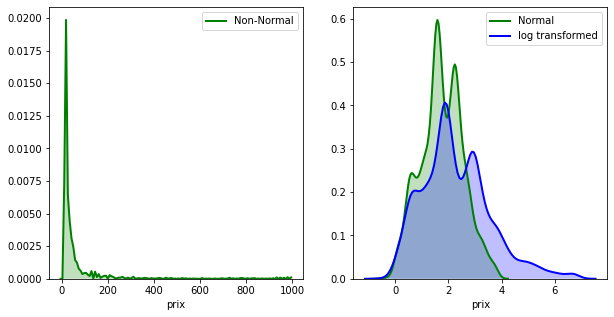

In [ ]:
#Box Cox transformtion 
#log transformation gives better results in terms of meansquarederror
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df.prix) 
  
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2) 
  
# plotting the original data(non-normal) and  
# fitted data (normal) 
sns.distplot(df.prix, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Non-Normal", color ="green", ax = ax[0]) 
  
sns.distplot(fitted_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Normal", color ="green", ax = ax[1]) 
sns.distplot(np.log(df.prix), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "log transformed", color ="blue", ax = ax[1])   
# adding legends to the subplots 
plt.legend(loc = "upper right") 
  
# rescaling the subplots 
fig.set_figheight(5) 
fig.set_figwidth(10) 
#del(df_final); df_final = pd.concat([features,pd.Series(fitted_data)],axis=1) ##uncomment line to use boxcox transformed data instead of log transformed data

Back transformation is needed if we wish to calculate the mean squared error and to get the final results back to their original form after training and validation of the model.
since we get better results with the log of the price the anti-log will be used (np.exp()) to compute the error terms.


```
np.exp(np.log(fitted_lambda * (insert test_data or train_data) + 1) / fitted_lambda) #expression for back transforming from box cox
np.exp(df.prix) #anti-log 
```



#Dimensionality reduction using Multiple factor analysis (MFA)

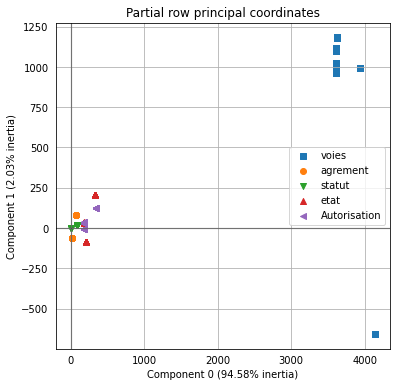

In [ ]:
from prince import MFA
#reduc.columns = [unidecode.unidecode(i) for i in reduc] 
reduc = df_misc.drop(columns=['tx rembours','date_diff']).astype('category')
groups = {}
for n in set([re.findall(r'^[a-zA-Z]{2,}',unidecode.unidecode(i))[0] for i in reduc.columns]):
      groups[n] = reduc.columns[reduc.columns.str.startswith(n)]
#groups
X_reduc = pd.concat([df_final,reduc],axis=1)
mfa = MFA(groups = groups, n_components = 2, n_iter = 3, random_state = 101)
mfa.fit_transform(X_reduc)
#mfa.plot_row_coordinates(X=X_reduc)
#mfa.partial_row_coordinates(X_reduc)
mfa.plot_partial_row_coordinates(X_reduc);

# Random Feature Selection, Data exploration, standard multiple linear regression and ZIP (Zero Inflated Poisson) 

In [ ]:
df.prix[df.prix<100].hist();

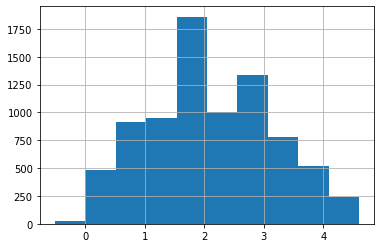

In [ ]:
pd.Series(["{0:.5f} %".format(i) for i in ((features.where(features==0).count()/len(features))*100)],features.columns)
np.log(df.prix[df.prix<100]).hist();

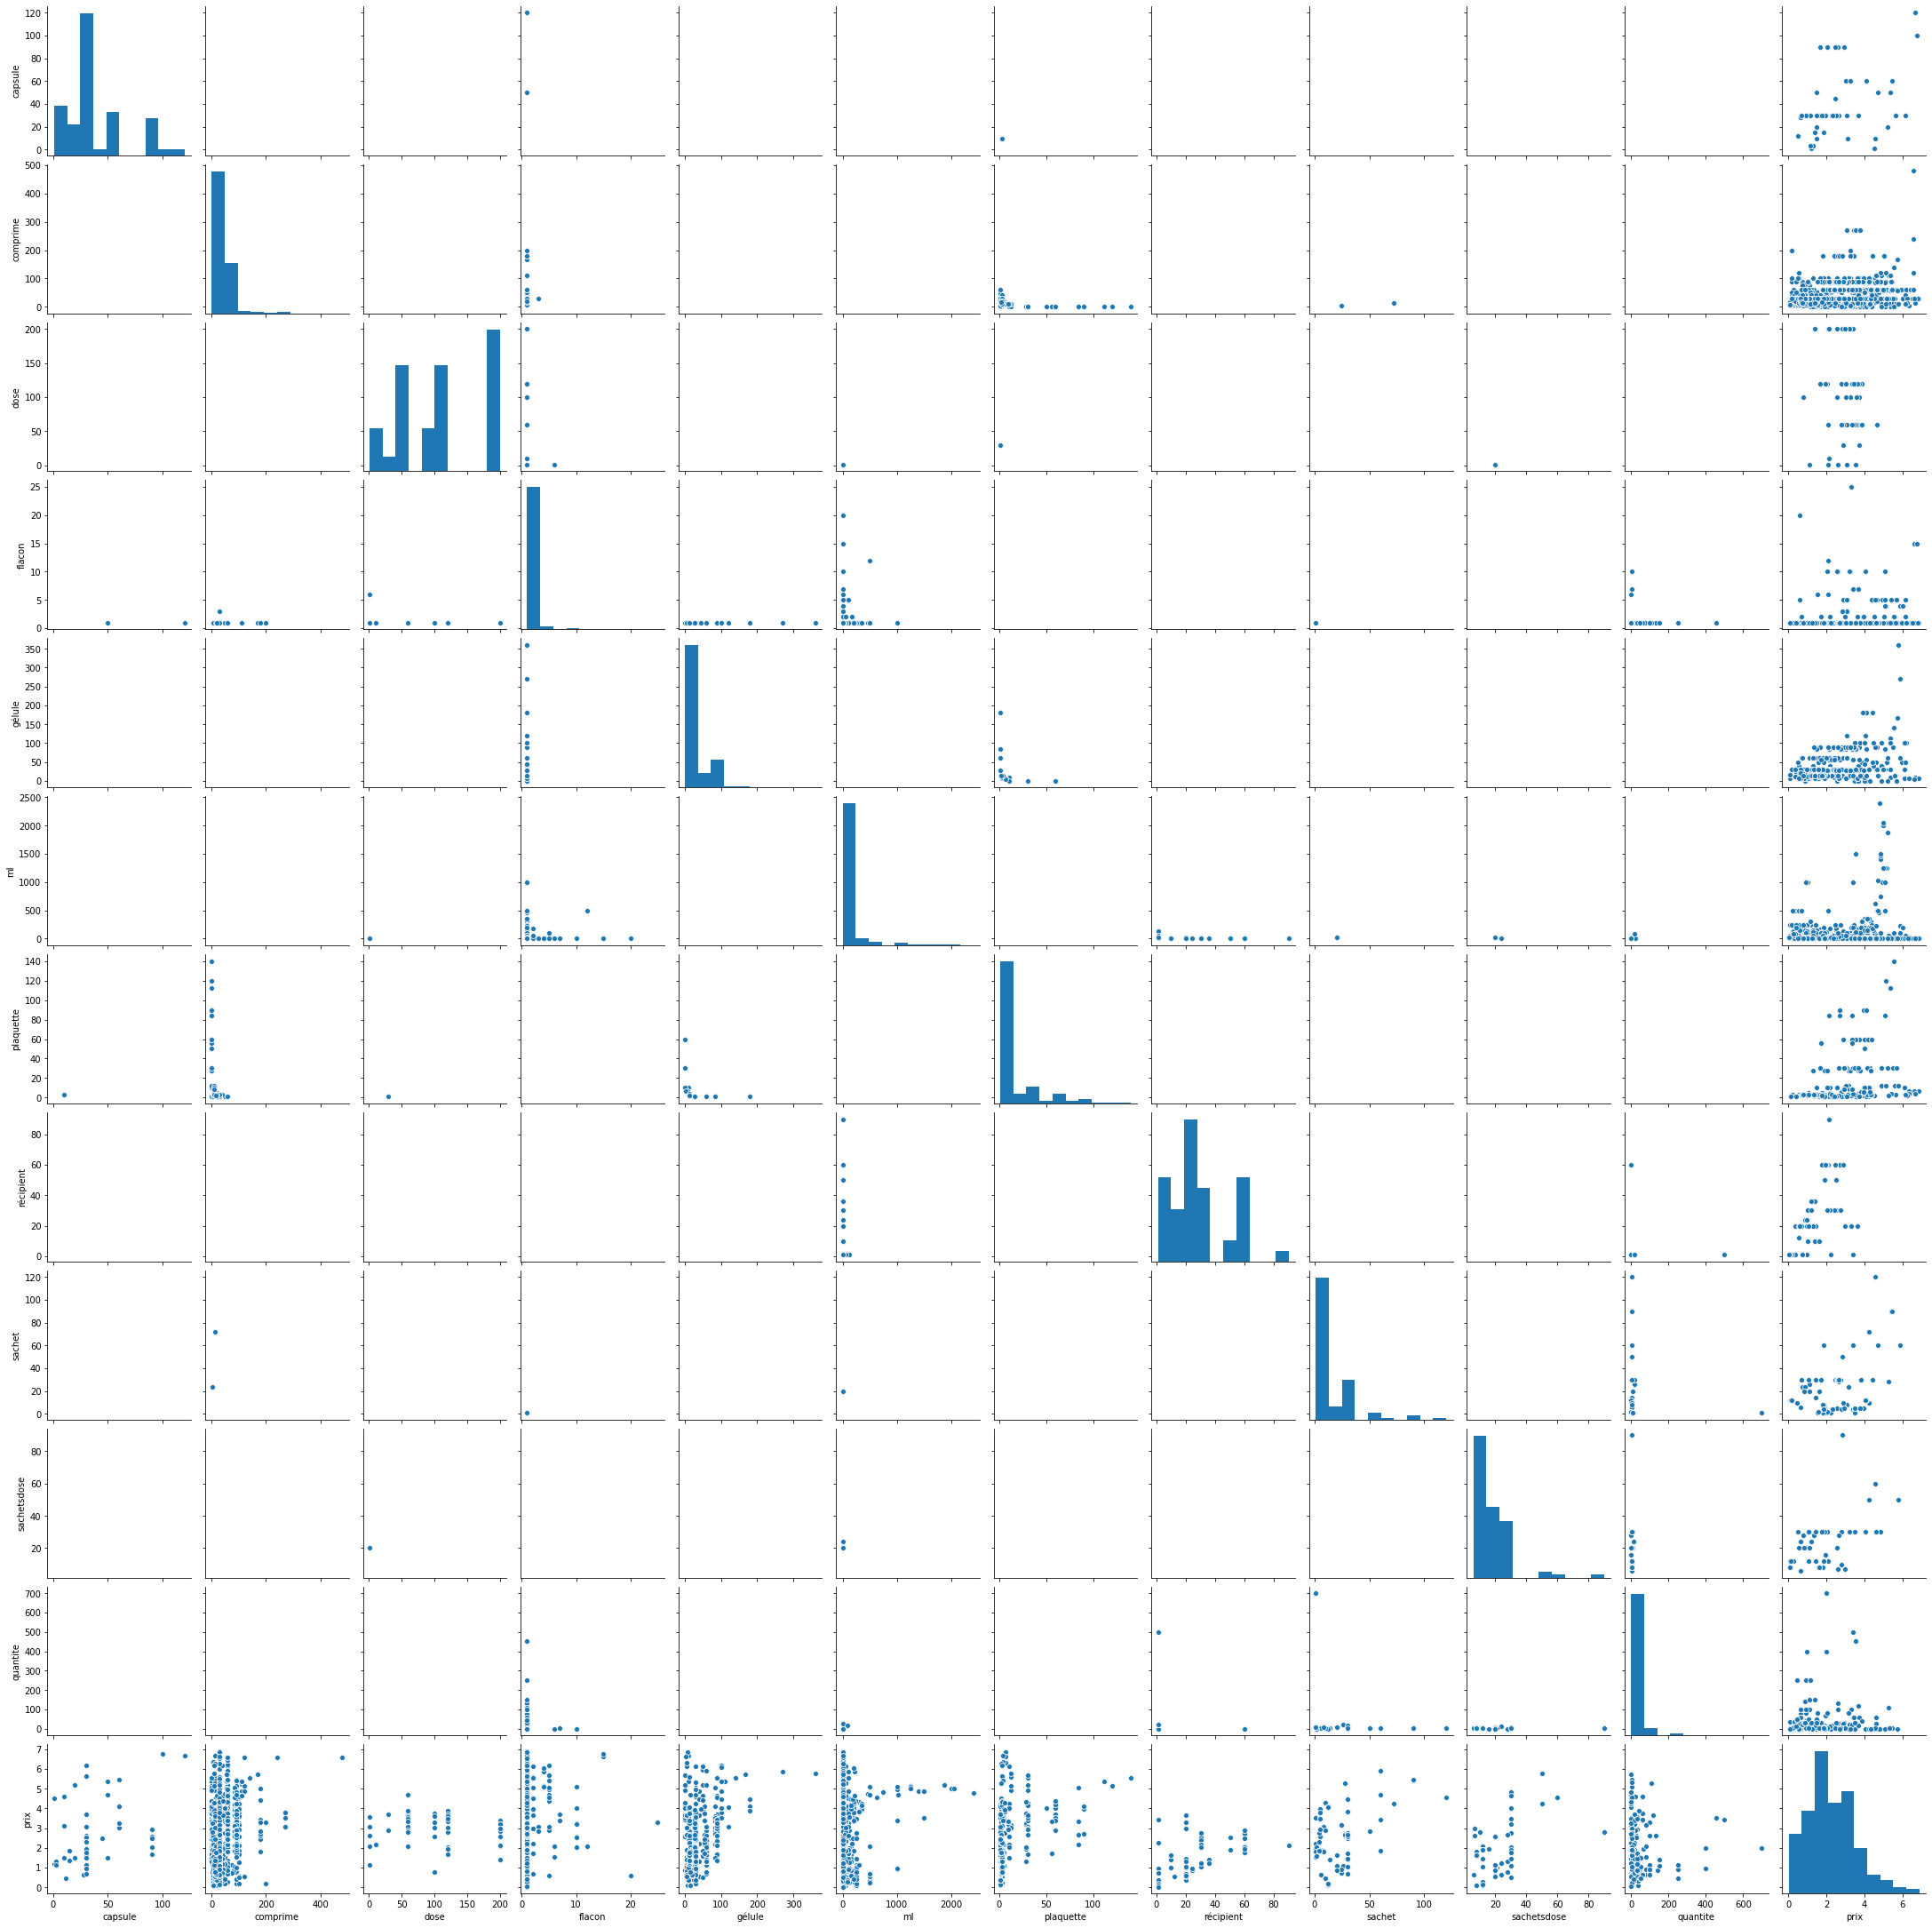

In [ ]:
sns.pairplot(df_final.iloc[:,np.where(df_final.mean()>0.099)[0]].where(df_final.iloc[:,np.where(df_final.mean()>0.099)[0]]>0));
#sns.pairplot(df_final.iloc[:,np.where(df_final.mean()>0.099)[0]]);

The pairplot below shows that there are lot of missing values equal to 0 in the data. This will most likely create bias in the estimation of the response variable. Maybe using a logistic regression to seperate null values and applying a linear regression on the values that are >0 could be the answer. (the response variable doesn't contain any missing values e.i. 0s).

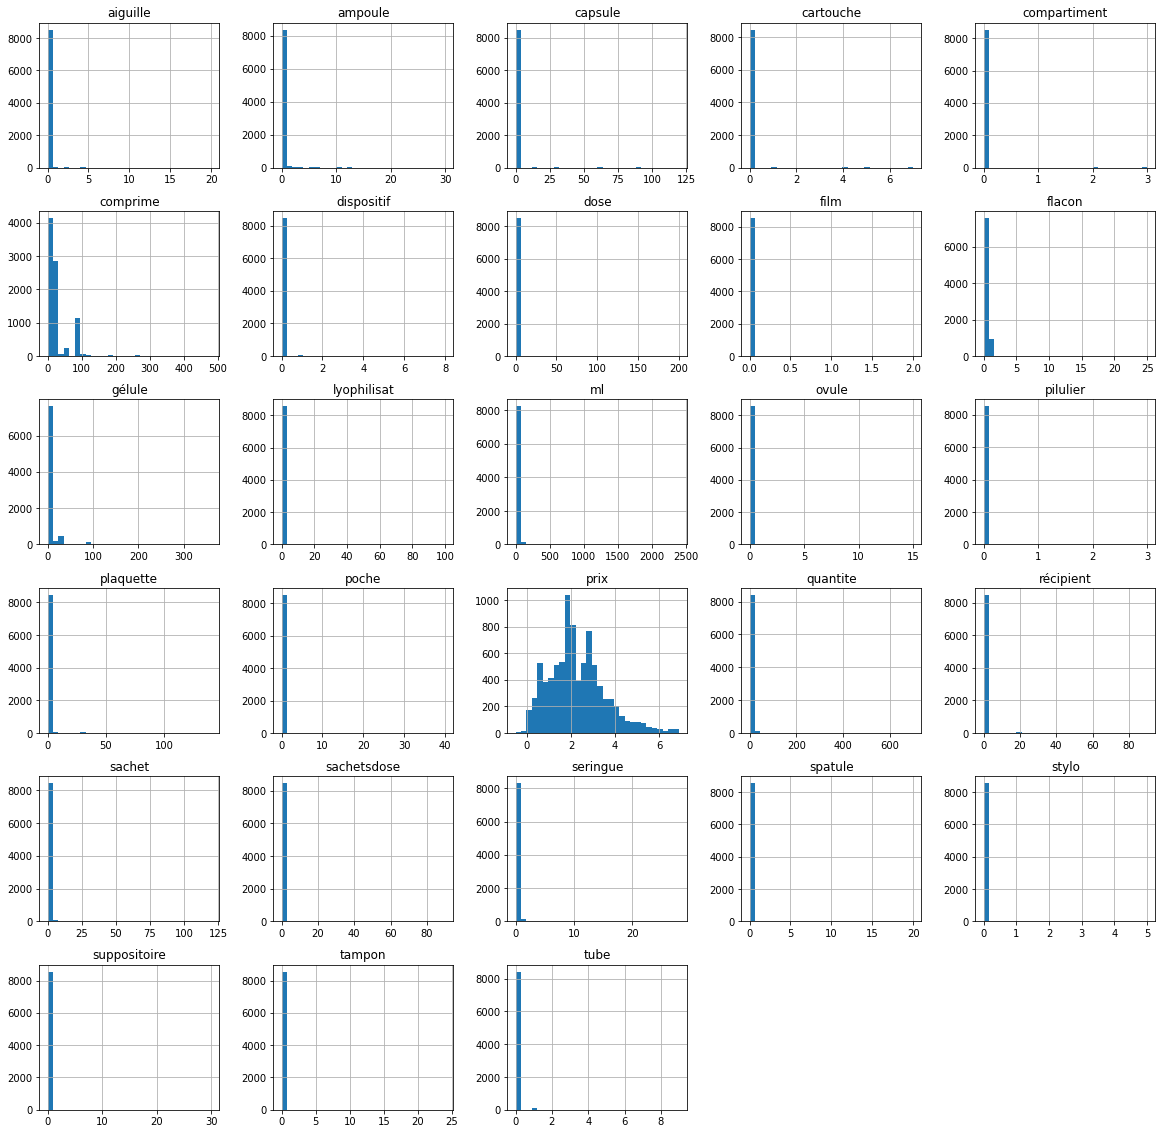

In [ ]:
df_final.hist(bins=30, figsize=(20, 20));

In [ ]:
from IPython.display import display
for i in df_final.iloc[:,:-1].columns:
    display(df_final.iloc[:,:-1][i].value_counts().reset_index().astype({i:"str"}).T.drop(index="index"));

,0,1,2,3,4,5,6,7,8
aiguille,8521,18,10,6,3,2,2,1,1


,0,1,2,3,4,5,6,7,8,9,10,11
ampoule,8380,87,25,23,20,10,9,4,2,2,1,1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
capsule,8512,22,6,4,3,3,3,2,2,2,1,1,1,1,1


,0,1,2,3,4,5
cartouche,8476,43,29,8,6,2


,0,1,2
compartiment,8539,20,5


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
comprime,3137,1720,1029,782,217,202,193,156,119,99,94,77,74,64,61,56,55,51,47,40,35,29,29,27,26,26,25,22,18,13,8,8,6,5,2,2,1,1,1,1,1,1,1,1,1,1


,0,1,2
dispositif,8476,85,3


,0,1,2,3,4,5,6,7
dose,8500,20,15,15,6,5,2,1


,0,1,2
film,8548,14,2


,0,1,2,3,4,5,6,7,8,9,10,11,12
flacon,7578,923,16,13,12,9,4,2,2,2,1,1,1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
gélule,7475,306,173,133,122,91,45,25,24,24,20,20,18,17,16,12,9,6,6,5,2,2,2,2,2,1,1,1,1,1,1,1


,0,1,2,3,4,5,6,7,8,9,10
lyophilisat,8545,4,3,2,2,2,2,1,1,1,1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110
ml,7286,108,90,88,83,69,63,61,55,52,49,41,35,32,29,29,28,25,25,24,22,20,19,15,13,12,12,11,8,7,7,7,6,5,5,5,4,4,4,4,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,0,1,2
ovule,8551,12,1


,0,1,2
pilulier,8524,26,14


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
plaquette,8313,60,49,27,22,13,13,11,11,9,6,6,6,5,4,3,2,1,1,1,1


,0,1,2,3,4,5,6,7,8,9
poche,8460,70,10,10,5,3,3,1,1,1


,0,1,2,3,4,5,6,7,8,9,10
récipient,8475,25,16,16,12,9,4,2,2,2,1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
sachet,8416,49,23,14,13,8,6,6,5,4,4,3,3,3,2,1,1,1,1,1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
sachetsdose,8465,24,23,22,14,3,3,2,2,1,1,1,1,1,1


,0,1,2,3,4,5,6,7,8,9,10
seringue,8300,148,35,31,13,13,9,9,3,2,1


,0,1,2
spatule,8551,11,2


,0,1,2,3
stylo,8546,13,3,2


,0,1,2,3,4,5,6,7
suppositoire,8542,9,4,3,2,2,1,1


,0,1,2,3,4,5,6
tampon,8544,6,5,5,2,1,1


,0,1,2,3,4,5
tube,8412,135,8,6,2,1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116
quantite,8150,69,24,21,14,14,12,11,11,11,11,10,10,9,9,8,8,7,6,6,6,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
reg = LinearRegression()
selector = RFE(reg)
selector = selector.fit(df_final.iloc[:,:-1],df_final.iloc[:,-1])
print(list(zip(selector.ranking_,df_final.columns)))
df_final.iloc[:,:-1].loc[:,selector.support_]

[(1, 'aiguille'), (11, 'ampoule'), (7, 'capsule'), (1, 'cartouche'), (1, 'compartiment'), (9, 'comprime'), (1, 'dispositif'), (12, 'dose'), (1, 'film'), (1, 'flacon'), (8, 'gélule'), (5, 'lyophilisat'), (15, 'ml'), (1, 'ovule'), (1, 'pilulier'), (3, 'plaquette'), (1, 'poche'), (10, 'récipient'), (4, 'sachet'), (13, 'sachetsdose'), (1, 'seringue'), (6, 'spatule'), (1, 'stylo'), (2, 'suppositoire'), (1, 'tampon'), (1, 'tube'), (14, 'quantite')]


,aiguille,cartouche,compartiment,dispositif,film,flacon,ovule,pilulier,poche,seringue,stylo,tampon,tube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
8561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
XTrainConst = sm.add_constant(df_final.iloc[:,:-1].loc[:,selector.support_])
mod = sm.OLS(df_final.iloc[:,-1].values,XTrainConst)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     85.53
Date:                Tue, 25 Aug 2020   Prob (F-statistic):          2.27e-215
Time:                        17:11:34   Log-Likelihood:                -13688.
No. Observations:                8564   AIC:                         2.740e+04
Df Residuals:                    8550   BIC:                         2.750e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2091      0.014    162.974   

In [ ]:
zip_training_results = sm.ZeroInflatedPoisson(endog=df_final.iloc[:,-1].values, exog=XTrainConst, exog_infl=df_final.iloc[:,:-1].loc[:,selector.support_],
                                              inflation='logit').fit()
print(zip_training_results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 2.180604
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                       y   No. Observations:                 8564
Model:             ZeroInflatedPoisson   Df Residuals:                     8550
Method:                            MLE   Df Model:                           13
Date:                 Tue, 25 Aug 2020   Pseudo R-squ.:                 -0.3193
Time:                         16:12:02   Log-Likelihood:                -18675.
converged:                       False   LL-Null:                       -14155.
Covariance Type:             nonrobust   LLR p-value:                     1.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
inflate_aiguille        -3.5339    138.795     -0.025      0.980    -275.566     268.499
inflate_cartouche       -5.8463      3.862     -1.514      0.130     -13.417       1.724
infl

In [ ]:
start = LinearRegressionResidualPlot(df_final.iloc[:,:-1].loc[:,selector.support_],df_final.iloc[:,-1].values)

start.diagnostic_plots(zip_training_results)

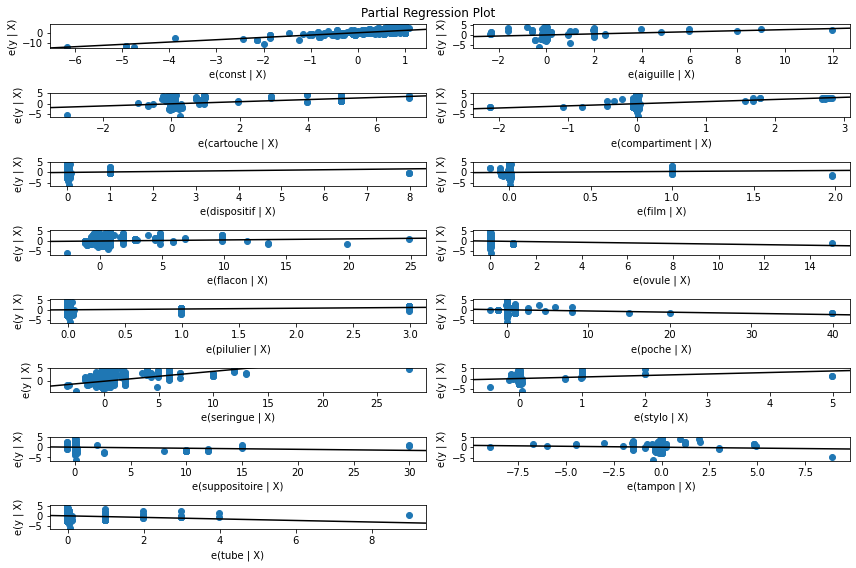

In [ ]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(res, fig=fig)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=del

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.115
 Model:                            OLS   Adj. R-squared:                  0.114
 Method:                 Least Squares   F-statistic:                     85.53
 Date:                Tue, 25 Aug 2020   Prob (F-statistic):          2.27e-215
 Time:                        17:12:00   Log-Likelihood:                -13688.
 No. Observations:                8564   AIC:                         2.740e+04
 Df Residuals:                    8550   BIC:                         2.750e+04
 Df Model:                          13                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 -------------------------------------------------------------------

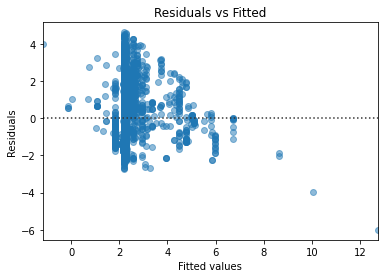

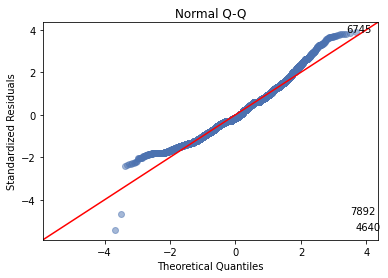

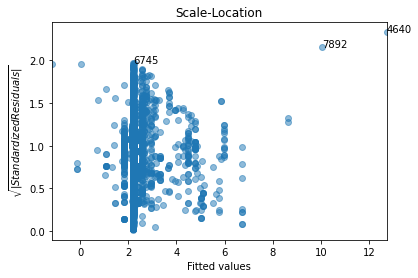

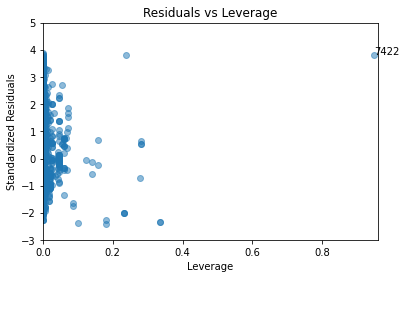

In [ ]:
start = LinearRegressionResidualPlot(XTrainConst,df_final.iloc[:,-1].values)

start.diagnostic_plots(res)

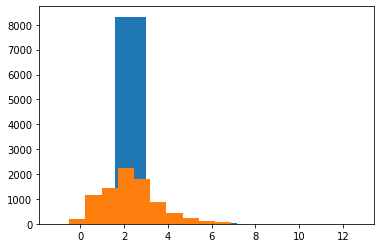

In [ ]:
plt.hist(res.predict())
plt.hist(df_final.prix)
plt.show();

In [ ]:
print("mean squared error : {}".format(mean_squared_error(df_final.prix,res.predict())))

mean squared error : 1.4303048482724627


#GridSearchCV for XGBOOST and Random Forest

In [ ]:
from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
X = pd.concat([(~df_final.iloc[:,:-1].apply(lambda x: x/x).isna()*1).astype('category')#0 for absence 1 for presence encoding of df_final variables
               ,df_final.iloc[:,:-1].rename(columns=lambda x: 'nb_'+x),df_misc,labels],axis=1)
y = df_final.iloc[:,-1]

In [ ]:
models1 = {
    #'XGBRegressor': XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    #'LassoRegression': linear_model.Lasso(max_iter=100000),
    #'ElasticNet': linear_model.ElasticNet(),
    #'HuberRegressor': linear_model.HuberRegressor()
    #'SVR' : SVR()
}

params1 = {
    #'XGBRegressor': { 'n_estimators' : [1000,500,200,40] , 'learning_rate' : [0.1] , 'max_depth': list(range(30,40,2)),
    #                 'min_child_weight': list(range(1,5,2))},
    'RandomForestRegressor': { 'n_estimators': [600,500,400,200],'max_depth' :[40,40,30]},
    #'LassoRegression': { 'alpha': [1e-06,1e-05,0.0001, 0.001, 0.005,0.01, 0.05, 0.1, 0.3, 1]},
    #'ElasticNet': { 'alpha': [0.1, 0.4, 0.7]},
    #'HuberRegressor': {'alpha': [1.2,1.35]}
    #'SVR' : {
    #        'C': [0.1, 1, 100, 1000],
    #        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    #        'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
    #    }
}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
helper1.score_summary(sort_by='mean_score')
#54 	RandomForestRegressor 	0.531099 	0.5455 	0.561033 	0.0119595 	NaN 	30 	NaN 	500 #the best

Save XGBoost results to file:

In [ ]:
#os.getcwd()
helper1.score_summary(sort_by='mean_score').to_csv(r'results1.csv', index = None, header=True)

XGBRegressor
RandomForestRegressor


In [ ]:
def mse_cv(model):
    kf = KFold(5, shuffle=True, random_state = 91).get_n_splits(X)
    mse= -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf)
    return(mse)
best_random = RandomForestRegressor(n_estimators=200, max_depth=30)
rfr_CV_best = mse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['RandomForest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,RandomForest Regressor,0.551154,0.021202,0.251812,0.51996,0.844233,0.679226


#Visualizations + feature importance (on log transformed response variable)

---
Results are based off XGBoost Regressor model that scored best.



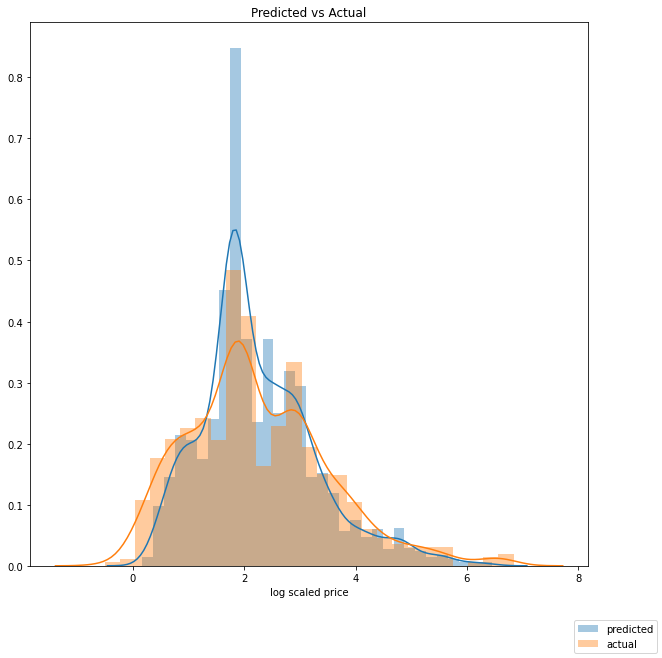

3095.1133153938476


In [ ]:
#model1 = SelectFromModel(best_random, prefit=True)
#X_train[:,model1.get_support()]
fig = plt.figure(figsize=(10,10))
sns.distplot(y_test_rfr)
sns.distplot(y_test)
fig.legend(labels=['predicted','actual'],loc='lower right')
plt.title("Predicted vs Actual")
plt.xlabel('log scaled price')
plt.show();
print(mean_squared_error(np.exp(y_test), np.exp(y_test_rfr)))

In [ ]:
[i for i in zip(np.exp(y_test_rfr),np.exp(y_test))][0:10]

[(1.4514748136042976, 1.42),
 (33.38845380788641, 14.790000000000001),
 (94.11057726240824, 129.03),
 (14.400539952442362, 14.2),
 (5.32867229964559, 4.16),
 (4.1720550146403514, 4.23),
 (5.8564837502219715, 2.53),
 (43.88350593207676, 42.57999999999999),
 (8.107536698618034, 10.129999999999999),
 (26.365457111852276, 11.269999999999998)]

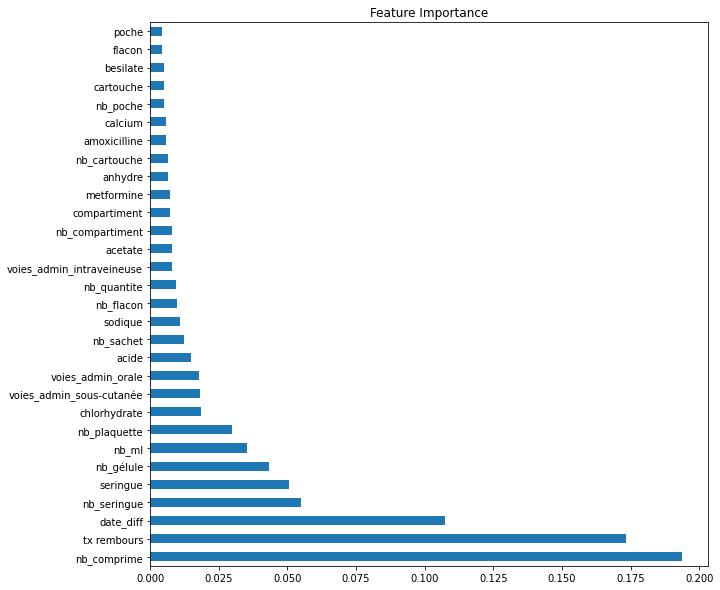

In [ ]:
feat_importances = pd.Series(best_random.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(figsize=(10,10),kind='barh')
plt.title('Feature Importance')
plt.show()

#Refitting and evaluation of model based on XGBoost variable selection

Test error is higher when refitting the model. 

In [ ]:
model1 = SelectFromModel(best_random, prefit=True)

In [ ]:
best_random = XGBRegressor(n_estimators=200, learning_rate=0.1,early_stopping=5,max_depth=13, min_child_weight=3, objective='reg:squarederror')
rfr_CV_best = mse_cv(best_random)
best_random.fit(X_train[:,model1.get_support()], y_train) 
y_train_rfr = best_random.predict(X_train[:,model1.get_support()])
y_test_rfr = best_random.predict(X_test[:,model1.get_support()])
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,0.525462,0.037714,0.596294,0.705017,0.631219,0.564733


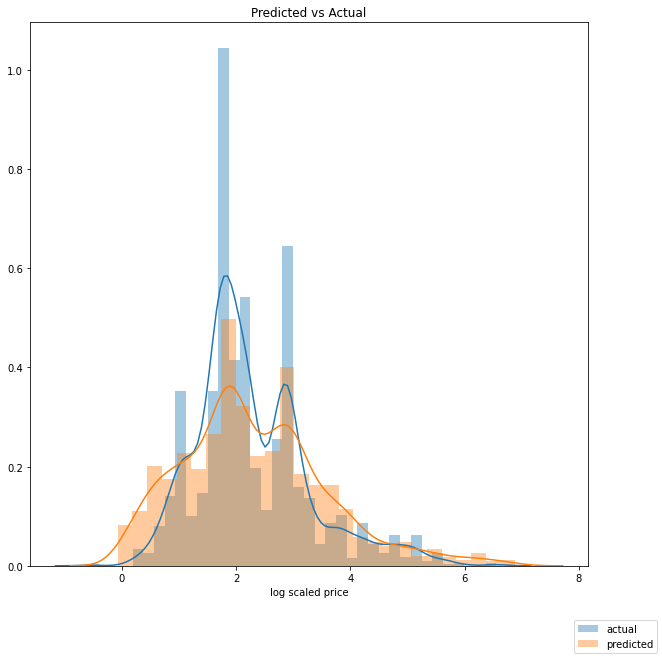

In [ ]:
#model1 = SelectFromModel(best_random, prefit=True)
#X_train[:,model1.get_support()]
fig = plt.figure(figsize=(10,10))
sns.distplot(y_test_rfr)
sns.distplot(y_test)
fig.legend(labels=['actual','predicted'],loc='lower right')
plt.title("Predicted vs Actual")
plt.xlabel('log scaled price')
plt.show();

In [ ]:
pd.DataFrame([y_test_rfr,y_test])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712
0,2.730591,2.278229,2.785622,1.559531,3.770461,2.259940,0.910021,3.879247,1.096965,2.204719,2.875610,2.875610,1.054253,2.094036,2.306617,1.520465,1.775874,5.031594,2.875610,2.550216,2.875610,0.677495,1.775874,1.069294,1.501349,1.775874,1.866453,3.068208,2.278229,2.875610,0.358173,1.089103,1.424542,3.247042,2.204719,1.775874,1.775874,2.875610,2.875610,2.875610,...,2.875610,2.204719,1.350731,3.068208,2.87561,4.774497,1.102558,1.775874,4.774497,3.222593,1.089103,2.875610,5.063492,1.775874,1.472792,1.093404,1.775874,0.910021,1.586986,2.004097,1.22732,1.089103,1.670347,2.875610,1.775874,3.068208,1.775874,1.501349,3.770422,1.179991,2.204719,3.430318,1.542159,2.476522,1.775874,3.247042,2.875610,2.875610,0.197040,2.029644
1,3.541539,1.423108,2.436241,3.033510,3.536602,2.315501,0.678034,3.844386,0.667829,1.778336,2.924773,2.698673,0.609766,2.096790,0.963174,1.249902,3.110399,6.588156,2.924773,1.396245,2.924773,0.542324,1.850028,2.071913,1.860975,1.884035,1.832581,3.629660,2.597491,3.165897,0.385262,1.184790,3.648838,2.026832,3.237501,1.850028,2.270062,2.463853,2.924773,2.881443,...,2.470639,1.776646,0.819780,4.177766,2.09679,5.779755,1.015231,1.801710,3.912623,3.078694,1.774952,2.766948,4.859657,1.850028,2.073172,1.040277,1.850028,0.920283,1.572774,1.556037,0.71295,1.184790,1.890095,3.165897,1.728109,3.092859,-0.040822,1.885553,4.218772,2.615204,2.564949,3.762827,2.598235,2.434490,0.712950,1.141033,2.693951,2.983153,0.076961,1.947338
